In [1]:
# General
import torch
import numpy as np
import matplotlib.pyplot as plt

# For dataloading
import tifffile as tiff
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# For architecture and training
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-labels.tif
/kaggle/input/train-volume.tif
/kaggle/input/challenge-error-metrics.bsh
/kaggle/input/test-volume.tif
/kaggle/input/train-labels.tif


In [3]:
class ISBIDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.images = tiff.imread(image_path).astype(np.float32)
        self.masks = tiff.imread(mask_path).astype(np.float32)
        self.transform = transform

        # Normalize images and masks to [0, 1]
        self.images = (self.images - np.min(self.images)) / (np.max(self.images) - np.min(self.images))
        self.masks = self.masks / 255.0

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def __len__(self):
        return len(self.images)

# Creating Dataset and Dataloader
Official cite for dataset and leaderboard: https://imagej.net/events/isbi-2012-segmentation-challenge
### TODO:
- Create train-val split for validating model performance
- Create test dataset (check right-side pannel)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = ISBIDataset(
    image_path="/kaggle/input/train-volume.tif",
    mask_path="/kaggle/input/train-labels.tif",
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True
)

In [5]:
# Function to display an image and its corresponding mask
def show_pair(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

Number of training pairs: 30
Number of training batches: 8
Image batch shape: torch.Size([4, 1, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])


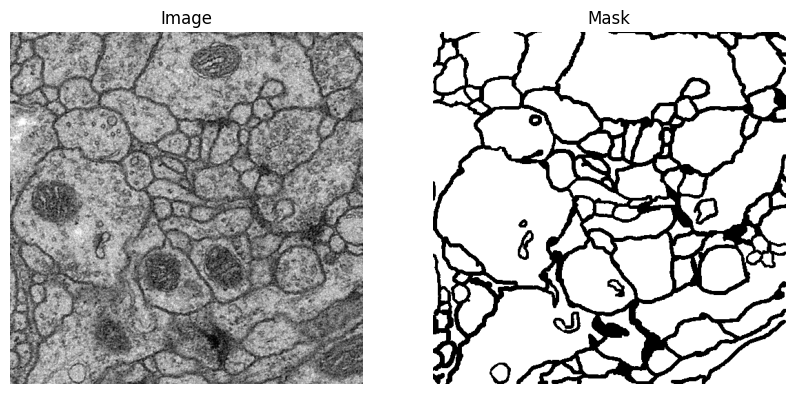

In [6]:
print(f'Number of training pairs: {len(train_dataset)}')
print(f'Number of training batches: {len(train_loader)}')

for image, mask in train_loader:
    print(f'Image batch shape: {image.shape}')
    print(f'Mask batch shape: {mask.shape}')

    show_pair(image[0], mask[0])

    break

# Model architecture
## Encoder Path (Contracting Path):

Convolutional Layers: 
These layers apply convolutions to extract features from the input image. Each convolutional layer is followed by a ReLU activation and batch normalization to standardize the outputs.

Max-Pooling Layers: 
These layers downsample the feature maps, reducing their spatial dimensions while increasing the depth (number of feature maps). This helps in capturing the contextual information.

## Decoder Path (Expanding Path):

Up-Convolutional (Transposed Convolutional) Layers: 
These layers upsample the feature maps, increasing their spatial dimensions. This helps in recovering the spatial resolution lost during downsampling in the encoder path.

Concatenation (Skip Connections): The feature maps from the encoder are concatenated with the upsampled feature maps in the decoder. This allows the model to retain fine-grained spatial information from the encoder, leading to more precise segmentation boundaries.

Final Convolution Layer:
This 1x1 convolution layer reduces the depth of the feature maps to the desired number of output channels, corresponding to the number of classes in the segmentation task.

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.enc5 = CBR(512, 1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))

        # Decoder
        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return self.final_conv(dec1)

# Training script
## Optimizer
Adam Optimizer: 
The Adam optimizer is used in the training loop. It is chosen because it is computationally efficient, has low memory requirements, and is well-suited for problems with large datasets and parameters.

## Loss Function:
Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss): This loss function combines a sigmoid layer and the binary cross entropy loss in one single class. It is appropriate for binary segmentation tasks.

## Hyperparameters
Batch Size: 4

Learning Rate: 0.001

Number of Epochs: 10

Image Size: 512x512 pixels

Number of Samples in Synthetic Dataset: 100

Number of Filters in Each Layer: 64, 128, 256, 512, and 1024 filters in subsequent layers.

Kernel Size: The convolutional layers use a kernel size of 3x3.

Padding: Padding is set to 1 to maintain the spatial dimensions of the feature maps.

Stride: The default stride of 1 is used for convolutions.

# UNet paper
## Symmetric Architecture: 
The U-Net has a symmetric architecture with an equal number of downsampling and upsampling steps, which helps in preserving spatial information and enabling precise localization.
## Skip Connections: 
The introduction of skip connections between the encoder and decoder paths allows the model to combine coarse and fine-grained features, improving segmentation accuracy.
## Data Augmentation: 
Extensive data augmentation techniques were used to artificially expand the training dataset. This included elastic deformations, which are particularly effective for medical image segmentation where anatomical variations are common.
## Efficient Use of GPU Memory: 
The architecture was designed to be efficient in terms of memory usage, allowing it to be trained on relatively small datasets.
## Application to Biomedical Image Segmentation: 
The U-Net was specifically designed for biomedical image segmentation and showed state-of-the-art performance on several medical image segmentation tasks.

The U-Net architecture's flexibility and effectiveness have made it widely applicable to various segmentation tasks beyond biomedical imaging, including satellite image analysis, autonomous driving, and more.

In [9]:
# Training and evaluation
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_ious = []
val_ious = []

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, jaccard_score

In [11]:
def calculate_metrics(preds, labels):
    preds = torch.sigmoid(preds).data.cpu().numpy()
    preds = (preds > 0.5).astype(np.uint8)
    labels = labels.data.cpu().numpy().astype(np.uint8)

    accuracy = accuracy_score(labels.flatten(), preds.flatten())
    iou = jaccard_score(labels.flatten(), preds.flatten(), average='binary')
    return accuracy, iou

In [12]:
model = UNet().cuda()
criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy with logits for binary segmentation
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20

In [17]:
print('Starting Training...')
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_iou = 0
    for images, masks in train_loader:
        images = images.cuda()
        masks = masks.cuda()
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        accuracy, iou = calculate_metrics(outputs, masks)
        epoch_accuracy += accuracy
        epoch_iou += iou
    
    avg_loss = epoch_loss / len(train_loader)
    avg_accuracy = epoch_accuracy / len(train_loader)
    avg_iou = epoch_iou / len(train_loader)
    
    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    train_ious.append(avg_iou)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, IoU: {avg_iou:.4f}")

print("Training complete.")

Starting Training...
Epoch [1/20], Loss: 0.3189, Accuracy: 0.8839, IoU: 0.8620
Epoch [2/20], Loss: 0.2857, Accuracy: 0.8960, IoU: 0.8755
Epoch [3/20], Loss: 0.2574, Accuracy: 0.9064, IoU: 0.8875
Epoch [4/20], Loss: 0.2372, Accuracy: 0.9116, IoU: 0.8935
Epoch [5/20], Loss: 0.2284, Accuracy: 0.9113, IoU: 0.8933
Epoch [6/20], Loss: 0.2148, Accuracy: 0.9155, IoU: 0.8979
Epoch [7/20], Loss: 0.2076, Accuracy: 0.9164, IoU: 0.8990
Epoch [8/20], Loss: 0.2061, Accuracy: 0.9160, IoU: 0.8982
Epoch [9/20], Loss: 0.2052, Accuracy: 0.9151, IoU: 0.8978
Epoch [10/20], Loss: 0.1934, Accuracy: 0.9199, IoU: 0.9032
Epoch [11/20], Loss: 0.1879, Accuracy: 0.9216, IoU: 0.9046
Epoch [12/20], Loss: 0.1817, Accuracy: 0.9245, IoU: 0.9079
Epoch [13/20], Loss: 0.1806, Accuracy: 0.9252, IoU: 0.9086
Epoch [14/20], Loss: 0.1818, Accuracy: 0.9237, IoU: 0.9071
Epoch [15/20], Loss: 0.1823, Accuracy: 0.9222, IoU: 0.9056
Epoch [16/20], Loss: 0.1818, Accuracy: 0.9241, IoU: 0.9071
Epoch [17/20], Loss: 0.1783, Accuracy: 0.924

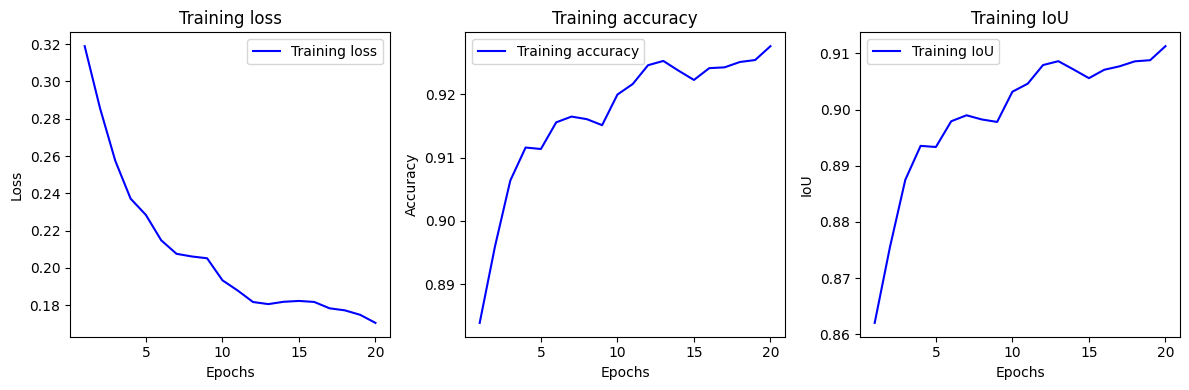

In [18]:
# Plotting the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_ious, 'b', label='Training IoU')
plt.title('Training IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()